In [1]:
%matplotlib notebook
#NOTA:
# Manylinux1 wheels have been used on the system, making *numpy* implementation underperforming by ~20%

In [2]:
import sys
print(sys.version)
import platform
print(platform.system())

3.5.3 (default, Jan 19 2017, 14:11:04) 
[GCC 6.3.0 20170118]
Linux


In [3]:
!uname -r
!lscpu
!free

4.16.0-0.bpo.2-amd64
Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                16
On-line CPU(s) list:   0-15
Thread(s) per core:    1
Core(s) per socket:    8
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 85
Model name:            Intel(R) Xeon(R) Gold 6134 CPU @ 3.20GHz
Stepping:              4
CPU MHz:               1200.482
BogoMIPS:              6400.00
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              1024K
L3 cache:              25344K
NUMA node0 CPU(s):     0,2,4,6,8,10,12,14
NUMA node1 CPU(s):     1,3,5,7,9,11,13,15
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid ape

In [4]:
!pip freeze|grep numpy
!pip freeze|grep numexpr
!pip freeze|grep numba
!pip freeze|grep pythran
!pip freeze|grep Cython

numpy==1.15.1
numpydoc==0.7.0
numexpr==2.6.8
numba==0.40.1
pythran==0.9.0
Cython==0.29


In [5]:
import math
import cmath
import numpy as np
import numba as nb
import numexpr as ne
from matplotlib.pyplot import subplots
from matplotlib.colors import LogNorm
from time import time
H = 0 #Miller index of reflection
K = 4 #Miller index of reflection
N = 100 #Number of units cells per direction
oversampling = 6 #Defines how much points are needed to describe a single Laue fringe (2 = Nyquist frequency)
e0 = 0.1 #Maximum strain at surface
w = 20. #Depth of strain profile below the surface

In [6]:
#Generate real and reciprocal space coordinates
n = np.arange(N)
m = np.arange(N)
h = np.arange(H-0.5, H+0.5, 1./(oversampling*N))
k = np.arange(K-0.5, K+0.5, 1./(oversampling*N))

In [7]:
def Circ_numpy(n, m, h, k, e0, w):
    N = len(n)
    k = k[:, np.newaxis]
    n = n[:, np.newaxis, np.newaxis]
    m = m[:, np.newaxis, np.newaxis, np.newaxis]
    radius = np.sqrt((n - N/2)**2 + (m - N/2)**2)
    support = np.where(radius > N/2, 0, 1)
    strain = e0 * (1 + np.tanh((radius-N/2) / w))
    return np.abs((support * np.exp(2j*np.pi*(h*(n+strain*(n-N/2)) + k*(m+strain*(m-N/2))))).sum(axis=0).sum(axis=0))**2

%time  intensity = Circ_numpy(n, m, h, k, e0, w)

CPU times: user 4min 32s, sys: 1min 46s, total: 6min 18s
Wall time: 6min 19s


<IPython.core.display.Javascript object>


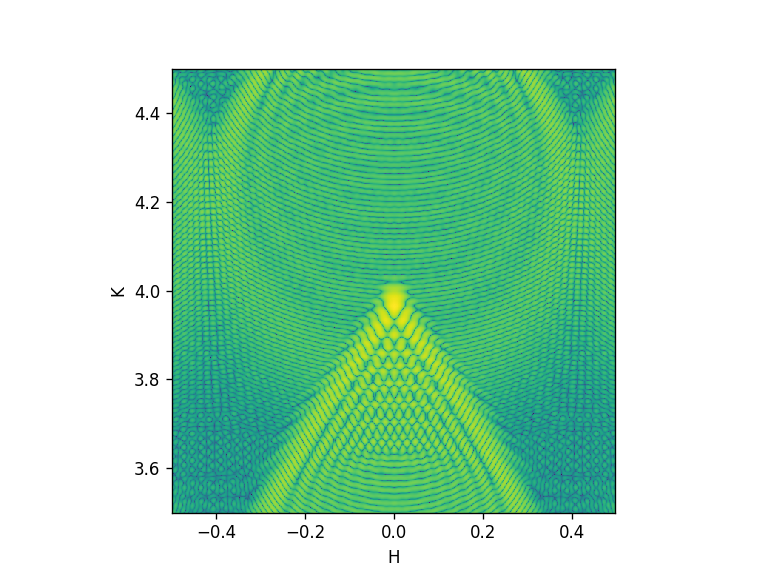

Text(0, 0.5, 'K')

In [8]:
ref_intensity = intensity
fig, ax = subplots()
ax.imshow(ref_intensity, extent=(h.min(), h.max(), k.min(), k.max()), norm=LogNorm(), origin = 'lower')
ax.set_xlabel('H')
ax.set_ylabel('K')

In [9]:
def Circ_hybrid(n, m, h, k, e0, w):
    result = np.zeros((h.size, k.size))
    N = len(n)
    n=np.atleast_2d(n).T
    m=np.atleast_2d(m)
    n_c = (n - N/2)
    m_c = (m - N/2)
    radius = np.sqrt(n_c**2 + m_c**2)
    strain = e0 * (1 + np.tanh((radius-N/2) / w))
    support = np.where(radius > N/2, 0, 1)
    
    n_s = n + strain * (n_c)
    m_s = m + strain * (m_c)
    #loop over the reciprocal space coordinates
    for i_k, v_k in enumerate(k):
        for i_h, v_h in enumerate(h): 
            tmp = (support * np.exp(2j*np.pi*(v_h*n_s + v_k*m_s))).sum()
            result[i_k, i_h] = tmp.real*tmp.real + tmp.imag*tmp.imag
    return result

#Compute and plot
%time  intensity = Circ_hybrid(n, m, h, k, e0, w)
print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max())

CPU times: user 4min 27s, sys: 10 ms, total: 4min 27s
Wall time: 4min 27s
Error: 1.862645149230957e-09


<IPython.core.display.Javascript object>


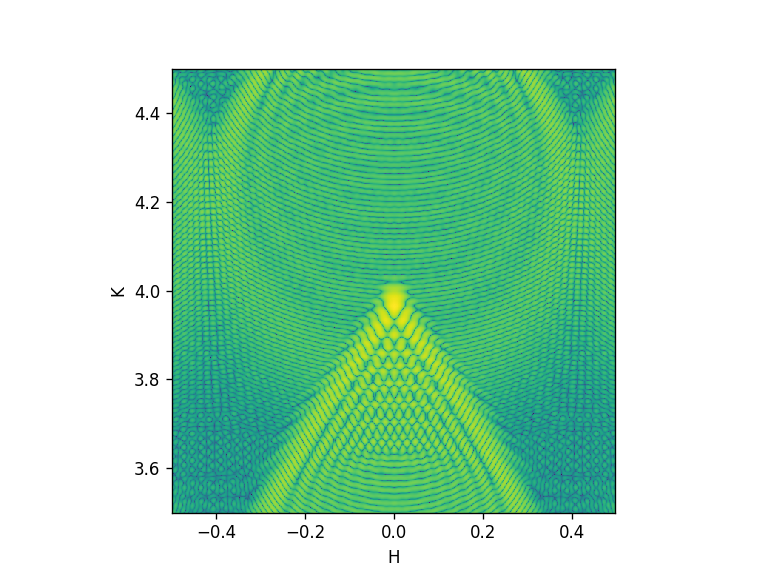

Text(0, 0.5, 'K')

In [10]:
fig, ax = subplots()
ax.imshow(intensity, extent=(h.min(), h.max(), k.min(), k.max()), norm=LogNorm(), origin = 'lower')
ax.set_xlabel('H')
ax.set_ylabel('K')

In [11]:
def Circ_numexpr(n, m, h, k, e0, w):
    N = len(n)
    h = h[np.newaxis, :, np.newaxis, np.newaxis]
    k = k[:, np.newaxis, np.newaxis, np.newaxis]
    n = n[np.newaxis, np.newaxis, :, np.newaxis]
    m = m[np.newaxis, np.newaxis, np.newaxis, :]
    radius = ne.evaluate("sqrt((n - N/2)**2 + (m - N/2)**2)")
    strain = ne.evaluate("e0 * (1 + tanh((radius-N/2) / w))")
    j2pi = np.pi*2j
    #loop over the reciprocal space coordinates
    tmp = ne.evaluate("where(radius > N/2, 0, exp(j2pi*(h*(n+strain*(n-N/2)) + k*(m+strain*(m-N/2)))))")
    tmp.shape = k.size, h.size, -1
    result = abs(tmp.sum(axis=-1))**2
    return result

#Compute and plot
%time  intensity = Circ_numexpr(n, m, h, k, e0, w)
print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max())

CPU times: user 4min 46s, sys: 20 s, total: 5min 6s
Wall time: 51 s
Error: 2.0954757928848267e-09


In [12]:
def Circ_numexpr_hybrid(n, m, h, k, e0, w):
    result = np.zeros((h.size, k.size))
    N = len(n)
    n=np.atleast_2d(n).T
    m=np.atleast_2d(m)
    n_c = (n - N/2)
    m_c = (m - N/2)
    radius = np.sqrt(n_c**2 + m_c**2)
    strain = e0 * (1 + np.tanh((radius-N/2) / w))
    support = np.where(radius > N/2, 0, 1)
    j2pi = np.pi*2j
    n_s = n + strain * (n_c)
    m_s = m + strain * (m_c)
    #loop over the reciprocal space coordinates
    for i_h, v_h in enumerate(h): 
        for i_k, v_k in enumerate(k):
            tmp = ne.evaluate("where(radius > N/2, 0, exp(j2pi*(v_h*n_s + v_k*m_s)))").sum()
            result[i_k, i_h] = tmp.real*tmp.real + tmp.imag*tmp.imag
    return result

#Compute and plot
%time  intensity = Circ_numexpr_hybrid(n, m, h, k, e0, w)
print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max())

CPU times: user 7min 38s, sys: 21.9 s, total: 8min
Wall time: 2min
Error: 1.862645149230957e-09


In [13]:
@nb.jit(nb.float64[:,:](nb.int64[:],nb.int64[:],nb.float64[:],nb.float64[:],nb.float64, nb.float64), 
        nopython=True, parallel=False, fastmath=False)
def Circ_numba_noparallel_slow(n, m, h, k, e0, w):
    result = np.zeros(len(h)*len(k), dtype=nb.float64)
    N = len(n)
    for i in nb.prange(len(h)*len(k)):
        tmp = 0j
        for i_n in n:
            for i_m in n:
                support = 1.0
                radius = math.sqrt((i_n - N/2)** 2 + (i_m - N/2)** 2)
                if (radius > (N/2)):
                    support = 0.0
                strain = e0 * (1 + math.tanh((radius-N/2)/w))
                tmp += support * cmath.exp(2j*cmath.pi*(h[i%len(h)]*(i_n+strain*(i_n-N/2)) + k[i//len(h)]*(i_m+strain*(i_m-N/2))))
        result[i] = abs(tmp)**2
    return result.reshape((len(k),len(h)))

In [14]:
#Compute and plot
%time  intensity = Circ_numba_noparallel_slow(n, m, h, k, e0, w)
print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max())

CPU times: user 7min 37s, sys: 2.55 s, total: 7min 40s
Wall time: 7min 37s
Error: 1.979060471057892e-08


In [15]:
@nb.jit(nb.float64[:,:](nb.int64[:],nb.int64[:],nb.float64[:],nb.float64[:],nb.float64, nb.float64), 
        nopython=True, parallel=False, fastmath=True)
def Circ_numba_noparallel_fast(n, m, h, k, e0, w):
    result = np.zeros(len(h)*len(k), dtype=nb.float64)
    N = len(n)
    for i in nb.prange(len(h)*len(k)):
        tmp = 0j
        for i_n in n:
            for i_m in n:
                support = 1.0
                radius = math.sqrt((i_n - N/2)** 2 + (i_m - N/2)** 2)
                if (radius > (N/2)):
                    support = 0.0
                strain = e0 * (1 + math.tanh((radius-N/2)/w))
                tmp += support * cmath.exp(2j*cmath.pi*(h[i%len(h)]*(i_n+strain*(i_n-N/2)) + k[i//len(h)]*(i_m+strain*(i_m-N/2))))
        result[i] = abs(tmp)**2
    return result.reshape((len(k),len(h)))

In [16]:
#Compute and plot
%time  intensity = Circ_numba_noparallel_fast(n, m, h, k, e0, w)
print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max())

CPU times: user 6min 48s, sys: 2.07 s, total: 6min 50s
Wall time: 6min 48s
Error: 4.959292709827423e-08


In [17]:
@nb.jit(nb.float64[:,:](nb.int64[:],nb.int64[:],nb.float64[:],nb.float64[:],nb.float64, nb.float64), 
        nopython=True, parallel=True, fastmath=False)
def Circ_numba_parallel(n, m, h, k, e0, w):
    result = np.zeros(len(h)*len(k), dtype=nb.float64)
    N = len(n)
    for i in nb.prange(len(h)*len(k)):
        tmp = 0j
        for i_n in n:
            for i_m in n:
                support = 1.0
                radius = math.sqrt((i_n - N/2)** 2 + (i_m - N/2)** 2)
                if (radius > (N/2)):
                    support = 0.0
                strain = e0 * (1 + math.tanh((radius-N/2)/w))
                tmp += support * cmath.exp(2j*cmath.pi*(h[i%len(h)]*(i_n+strain*(i_n-N/2)) + k[i//len(h)]*(i_m+strain*(i_m-N/2))))
        result[i] = abs(tmp)**2
    return result.reshape((len(k),len(h)))

In [18]:
#Compute and plot



#%time  intensity = Circ_numba_parallel(n, m, h, k, e0, w)

# This did not finish in a night ... there is probably a bug in the numba installation.

#print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max())

In [19]:
%load_ext pythran.magic

In [20]:
%%pythran -fopenmp

#pythran export Circ_pythran(int[] or float[], int[] or float[], float[], float[], float, float or int)
import numpy as np

def Circ_pythran(n, m, h, k, e0, w):
    result = np.zeros((len(k),len(h)), dtype=np.float64)
    N = len(n)
    "omp parallel for"
    for i_h, v_h in enumerate(h): #loop over the reciprocal space coordinates
        for i_k, v_k in enumerate(k):
            tmp = 0j
            for i_n in n:
                for i_m in n:
                    radius = np.sqrt((i_n - N/2.)** 2 + (i_m - N/2.)** 2)
                    if (radius > (N/2.)):
                        continue
                    strain = e0 * (1 + np.tanh((radius-N/2.)/w))
                    tmp += np.exp(2j*np.pi*(v_h*(i_n+strain*(i_n-N/2.)) + v_k*(i_m+strain*(i_m-N/2.))))
            result[i_k, i_h] = abs(tmp)**2
    return result


In [21]:
#Compute and plot
%time  intensity = Circ_pythran(n, m, h, k, e0, w)
print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max())

CPU times: user 5min 56s, sys: 0 ns, total: 5min 56s
Wall time: 22.7 s
Error: 2.0023435354232788e-08


In [22]:
%load_ext Cython

In [23]:
%%cython -a --compile-args=-fopenmp --link-args=-fopenmp
import numpy as np
from cython.parallel import prange
import cython

from libc.math cimport sqrt, tanh

cdef extern from "complex.h" nogil:
    double complex cexp(double complex)
    
@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
def Circ_cython(long[::1] n, 
                long[::1] m, 
                double[::1] h, 
                double[::1] k,
                double e0,
                int w):
    cdef:
        double[:, ::1] result
        double r_part, i_part, v_h, v_k, radius, strain
        double complex tmp, two_j_pi
        int i_h, i_k, i_m, i_n, size_h, size_k, N
        
    two_j_pi = np.pi*2j
    size_h = h.size
    size_k = k.size
    N = n.size
    result = np.zeros((size_k, size_h))
    #loop over the reciprocal space coordinates
    for i_k in prange(size_k, nogil=True):
        v_k = k[i_k]
        for i_h in range(size_h): 
            v_h = h[i_h]
            tmp = 0
            #loop and sum over unit-cells
            for i_n in range(N):
                for i_m in range(N):
                    radius = sqrt((i_n - N/2.)** 2 + (i_m - N/2.)** 2)
                    if (radius > (N/2.)):
                        continue
                    strain = e0 * (1 + tanh((radius-N/2.)/w))
                    tmp = tmp + cexp(two_j_pi*(v_h*(i_n+strain*(i_n-N/2.)) + v_k*(i_m+strain*(i_m-N/2.))))
            r_part = tmp.real
            i_part = tmp.imag
            result[i_k, i_h] += r_part*r_part + i_part*i_part

    return result


In [24]:
#Compute and plot
%time  intensity = Circ_cython(n, m, h, k, e0, w)
print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max())

CPU times: user 6min 4s, sys: 4.79 ms, total: 6min 4s
Wall time: 23.4 s
Error: 2.0023435354232788e-08
